In [1]:
import requests
URL = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
response = requests.get(URL)
open("names.txt", "wb").write(response.content)

228145

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/lucasvanwalstijn/miniconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('./names.txt', 'r') as file:
    names = file.read().splitlines()

In [4]:
letters = sorted(list(set([letter for name in names for letter in name])))

In [5]:
assert len(letters) == 26

In [6]:
i_to_s = {i+1: s for i, s in enumerate(letters)}
i_to_s[0] = '.'

s_to_i = {s: i for i, s in i_to_s.items()}

In [7]:
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [8]:
# Counting model:

C = torch.zeros(27,27, dtype=torch.int32)
for name in names:
    name = '.' + name + '.'
    for ch1, ch2 in zip(name, name[1:]):
        C[s_to_i[ch1], s_to_i[ch2]] += 1

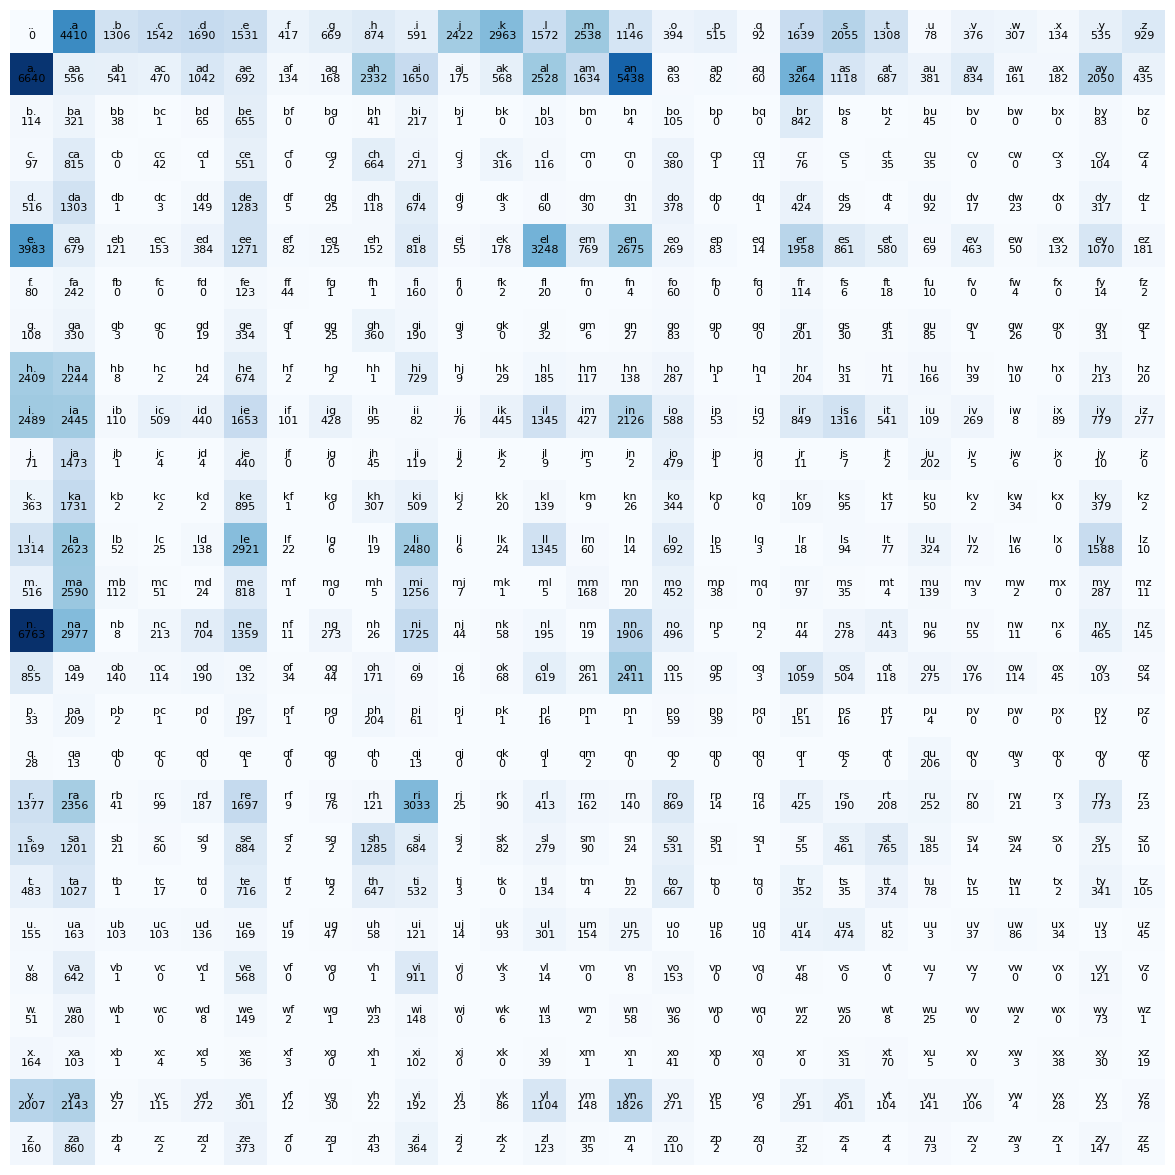

In [9]:
plt.figure(figsize = (15,15))
ax = plt.imshow(C, cmap='Blues');
plt.axis('off');
for i in range(27):
    for j in range(27):
        text = i_to_s[i] + i_to_s[j]
        plt.text(j, i, text, fontsize=8, ha='center', va='bottom')
        plt.text(j, i, str(C[i,j].item()), fontsize=8, ha='center', va='top')

In [10]:
# Smoothing
C = C+1

# Use this model to generate some names:

P = C / C.sum(1, keepdim=True)

assert P[0].sum().item() == 1.0

g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    sampled_i = 0
    name = ""
    while True:
        sampled_i = int(torch.multinomial(P[sampled_i], 1, replacement=True, generator=g).item())
        sampled_s = i_to_s[sampled_i]
        if sampled_i == 0:
            break
        name += sampled_s
    print(name)

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl


In [11]:
# What's the negative loss likelihood of our model?
sumlogprob = torch.tensor(0.0)
count = 0
for name in names:
    name = '.' + name + '.'
    for ch1, ch2 in zip(name, name[1:]):
        prob = P[s_to_i[ch1], s_to_i[ch2]]
        logprob = torch.log(prob)
        sumlogprob += logprob
        count += 1
nll = -sumlogprob / count
print(f'{nll.item()=}')


nll.item()=2.4543561935424805


In [12]:
# Predictions for totally untrained model:

g = torch.Generator().manual_seed(2147483647)

W_ = torch.ones((27,27))
P_ = W_ / W_.sum(1, keepdim=True)

for i in range(5):
    sampled_i = 0
    name = ""
    while True:
        sampled_i = int(torch.multinomial(P_[sampled_i], 1, replacement=True, generator=g).item())
        sampled_s = i_to_s[sampled_i]
        if sampled_i == 0:
            break
        name += sampled_s
    print(name)

qvsaayxbqrqmyqwuznivanukotdjvdhd
qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu
idcx
cekmzucjnjoeovjvrggqrjr
cfbhabkslpokc


In [13]:
# What's the negative loss likelihood of untrained model?

sumlogprob = torch.tensor(0.0)
count = 0
for name in names:
    name = '.' + name + '.'
    for ch1, ch2 in zip(name, name[1:]):
        prob = P_[s_to_i[ch1], s_to_i[ch2]]
        logprob = torch.log(prob)
        sumlogprob += logprob
        count += 1
        # print(ch1, ch2, f'{prob.item():.4f}', f'{logprob.item():.4f}')
nll = -sumlogprob / count
print(f'{nll.item()=}')


nll.item()=3.2960469722747803


In [14]:
# Now let's build a more generic model, and use the negative log likelihood as loss and train the model

In [15]:
# Create datasets:

xs = []
ys = []

for name in names:
    name = '.' + name + '.'
    for x, y in zip(name, name[1:]):
        xs.append(s_to_i[x])
        ys.append(s_to_i[y])

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [16]:
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for i in range(100):
    x_enc = torch.nn.functional.one_hot(xs, num_classes=27).float()
    logits = x_enc @ W # log counts
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    nll = -probs[torch.arange(num), ys].log().mean()
    print(nll.item())
    nll.backward()

    W.data += -torch.tensor(50.0) * W.grad
    W.grad = None


3.340726375579834
3.0792899131774902
2.9223504066467285
2.829867124557495
2.7666335105895996
2.7211520671844482
2.6872754096984863
2.6611478328704834
2.6403698921203613
2.6234242916107178
2.609321355819702
2.5973892211914062
2.5871543884277344
2.578273296356201
2.5704898834228516
2.5636088848114014
2.5574798583984375
2.5519843101501465
2.547027111053467
2.542532444000244
2.538437843322754
2.53469181060791
2.531251907348633
2.5280814170837402
2.5251505374908447
2.522433042526245
2.519906997680664
2.517552375793457
2.515353202819824
2.5132946968078613
2.511363983154297
2.509549617767334
2.5078415870666504
2.5062308311462402
2.5047097206115723
2.5032708644866943
2.501908302307129
2.5006155967712402
2.4993879795074463
2.498220443725586
2.4971086978912354
2.496049642562866
2.4950385093688965
2.4940731525421143
2.493149757385254
2.4922659397125244
2.4914193153381348
2.490607976913452
2.4898288249969482
2.4890806674957275
2.4883615970611572
2.4876701831817627
2.487004280090332
2.4863629341125

In [17]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
    
        xenc = torch.nn.functional.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(i_to_s[int(ix)])
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondmaisah.
anchshizarie.
